# This imports CSV data from CBOE and then processes it 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
from datetime import timedelta

In [2]:
#Does not account for market holidays 
def makeFileList(startDate,endDate,directory):
    cDate = startDate 
    fileList = []
    startString = "UnderlyingOptionsIntervalsCalcs_60sec_" 
    endString = ".csv"
    oneDay = timedelta(days=1) #defines a 1day time delta so you can iterate forward one day 
    while(cDate<=endDate): 
        if not ((cDate.weekday()==5) or (cDate.weekday()==6)): #if cDate is saturday or sunday don't do the following thing ADD hol later
            fileName = directory+startString+str(cDate.date())+endString
            fileList.append(fileName)
        cDate = cDate + oneDay

    return fileList

In [3]:
#some useful classes 
class Indicator: 
    def __init__(self):
        self.stockData = TSlist()
        
    def getMA(self,minBack):
        movAvg = np.ndarray([len(self.stockData.getv),2])
        for i in range(0,len(self.stockData.getv)):
            movAvg[i][0] = self.stockData.getValue(i,0)
            if i<minBack:
                movAvg[i][1] = 0
            else:
                total = 0 
                for j in range(0,minBack):
                    total = total+stockData.getValue(i-j,1)
                movAvg[i][1] = (total+0.0)/(minBack+0.0)
        return movAvg
    
    def updateStockData(self,newQuote):
        self.stockData.appendTS(newQuote[0],newQuote[1])
               
        
class TSlist:
    def __init__(self):
         self.t = []
         self.v = []
    def getValue(row,col):
        if(col==0):
            return self.t[row]
        if(col==1):
            return self.v[row]
    def gett():
        return self.t
    def getv():
        return self.v
    
    def setCell(self,row,col,newValue):
        if(col==0):
            self.t[row] = v
        if(col==1):
            self.v[row] = newValue 
    def appendTS(self,tValue,vValue):
        self.t.append(tValue)
        self.v.append(vValue)
    def makeNParray(self):
        return np.array([t,v]).transpose() 
    


In [16]:
def dataProcessor(csvFileName,optionD,positions,indicator): #for clarity of the code this is not generalized and will only work with CBOD database 
    #this is an array of titles that corresponds to the order in the csv files 
    #for example tiles[3] returns a string root 
    #this makes the code much more readable 
    titles = ['underlying_symbol','quote_datetime','root','expiration','strike','option_type','open','high','low','close','trade_volume','bid_size','bid','ask_size','ask','underlying_bid','underlying_ask','implied_underlying_price','active_underlying_price','implied_volatility	delta','gamma','theta','vega','rho','hash_value']
    i  = 0 
    csvD = {} #csvDictionary give it a column name and it returns its index 
    for i in range(0, len(titles)): 
        csvD[titles[i]] = i 
    j = 0 
    #this is needed for the stragegy to fuction properly 
    minList = [] #minute list 
    with open(csvFileName, 'rb') as f: #opens the 
        reader = csv.reader(f)
        for row in reader:
            #this processes the string and makes sure each part of the list has the correct datatype 
            if (j ==0):  #skips the first header line 
                j = 1 
                continue 
            hashValue =  row[csvD['root']]  + '|' +row[csvD['expiration']]+ '|'+row[csvD['strike']]+'|'+row[csvD['option_type']]
            row[csvD['quote_datetime']] = datetime.strptime(row[csvD['quote_datetime']] ,'%Y-%m-%d %H:%M:%S') #these should be changed to datetime64 
            row[csvD['expiration']] = datetime.strptime(row[csvD['expiration']] +' 16:00:00','%Y-%m-%d %H:%M:%S') #assumes 4:00 est close
            for i in range(csvD['strike'],csvD['rho']+1): #turns all of the float rows into floats 
                if i != csvD['option_type']: #avoids the option time column when trying to float convert 
                    row[i] = float(row[i])
            row.append(hashValue)
            #this part does the stragety stuff 
            result = strategy(row,minList,csvD,indicator)
            if(result is not None):
                positions.append(result)
            
            #this part adds the  option information to optionD 
            if not hashValue in optionD: #if the hashValue isn't in option D ...
                dic = {}  #make a new dictionary 
                for title in titles:  #go through the titles array 
                    dic[title] = [row[csvD[title]]] #make a dictionary where the key is the title and the value is a list 
                                                    #where the first enitry is the value in the row under that tile 
                optionD[hashValue] = dic #store the reference to the new dictionary in the optionD dictionary 
            else:
                dic = optionD[hashValue] #dictionary already exists, so get its reference 
                for title in titles: 
                    dic[title].append(row[csvD[title]]) #append the rows to the list 
                    
    return optionD 
    

In [17]:
def strategy(row,minList,csvD,indicator):
    if (len(minList)==0 or minList[-1][csvD["quote_datetime"]]==row[csvD["quote_datetime"]]):
        minList.append(row)
        return None 
    else: 
        return decision1(minList,csvD,indicator)
        #you are at the end of a min 
        

In [18]:
def decision1(minList,csvD,indicator):
    bestPosition = minList[0] 
    for positions in minList: 
        if(positions[csvD["bid"]]>bestPosition[csvD["bid"]]):
            bestPosition = positions
    if(bestPosition[csvD["bid"]]>100):
        return bestPosition
    else:
        return None 

#### This is the main function for this program. The following block of code takes a while to run

In [19]:
#this is the "main" method for extracting and processing the data 
startDate = datetime.strptime("2009-03-06","%Y-%m-%d")
endDate = datetime.strptime("2009-03-06","%Y-%m-%d")
directory = "C:/data/"
fileList = makeFileList(startDate,endDate,directory)
positions = []
#csvFileName = 'C:/data/UnderlyingOptionsIntervalsCalcs_60sec_2009-03-02.csv'
optionD = {} #this is dictionary of all of the different options. Give a hash function, get an option time series 
indicator = Indicator()
for csvFileNames in fileList: 
    optionD = dataProcessor(csvFileNames,optionD,positions,indicator)
    

In [8]:
optionPD = {} #creates a new dictionary of all of the options as a Pandas Dataframe 
nonZeroList = []
for key in optionD: 
    tmp = pd.DataFrame(optionD[key]) #turns the dictionaries into a pandas dataframe
    optionPD[key] = tmp 
    if(tmp["bid"].mean()>100): #this is an efficent way to generate a list of the options you want
        nonZeroList.append(key)


1016060


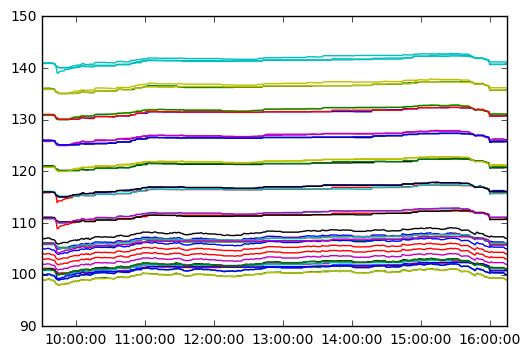

In [9]:
%matplotlib inline
for keys in nonZeroList: 
    tempPD = optionPD[keys] #stores some option PD in tempPD
    plt.plot(tempPD["quote_datetime"],tempPD["bid"])